## Importings

In [16]:
# Importing basic stuff
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Train test split
from sklearn.model_selection import train_test_split

# Vectorizers
from sklearn.feature_extraction.text import CountVectorizer

# Models
from sklearn.linear_model import LogisticRegression

# evaluation
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

## Reading data

In [2]:
# Naming the columns of the dataset. https://stackoverflow.com/questions/31645466/give-column-name-when-read-csv-file-pandas
colNames = ['polarity', 'title', 'text']

# Loading Dataset and assigning column names
df = pd.read_csv("./data/test.csv", names=colNames, header=None)

# Resizing the dataset, for faster computing time. A random sample from the dataset https://stackoverflow.com/questions/40986230/reduce-dataframe-size-in-pandas
df = df.sample(frac=0.1) # Get 10% of the data

In [3]:
# Looking on the data
(
    df
    #.sample(5)
    #.dtypes
    .info()
    #.loc[:,["polarity"]]
    #.loc[:,["title"]]
    #.loc[:,["text"]]
    #.value_counts()
    #.value_counts(normalize=True) # For seeing the count in %
    #.describe()
)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40000 entries, 84512 to 189498
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   polarity  40000 non-null  int64 
 1   title     39999 non-null  object
 2   text      40000 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB


In [4]:
# Cleaning the data. Removing null values and only take the values that contain info.
# https://stackoverflow.com/questions/13413590/how-to-drop-rows-of-pandas-dataframe-whose-value-in-a-certain-column-is-nan
df.dropna(how='any')
df = df[df['title'].notna()]
df = df[df['text'].notna()]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39999 entries, 84512 to 189498
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   polarity  39999 non-null  int64 
 1   title     39999 non-null  object
 2   text      39999 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB


In [5]:
# Assigning values to X and Y
xText = df.text
xTitle = df.title
y = df.polarity

xText.head(1)

84512    I had this with my daughter, and it was very w...
Name: text, dtype: object

In [6]:
# Train test split of data
X_train, X_test, y_train, y_test = train_test_split(xText, y, test_size=0.33, random_state=42)

In [7]:
# Looking on one example
print("type of X_train: {}".format(type(X_train)))
print("length of X_train: {}".format(len(X_train)))
print("X_train[1]:\n{}".format(X_train.iloc[1500]))

type of X_train: <class 'pandas.core.series.Series'>
length of X_train: 26799
X_train[1]:
ANY compilation that goes under the uber-boring and generic title "Greatest Hits" better, at the very least, live up to the name, no excuses. This compilation, although including many of their hits, is missing "All That Glitters Isn't Gold," which hit #49 and thus, technically, one of their greatest hits. Any comp album with a misleading title is an insult and a failure. Please, go out and get these songs by buying the three fantastic albums they came from and show this awesome group of women some true respect.


## Basics - Countvectorizer plus logistic regression

In [8]:
# Applying Count vectorizer
vect = CountVectorizer()
vect.fit(X_train)
X_train = vect.transform(X_train)
X_test = vect.transform(X_test)


In [9]:
# Looking on the vectorized features. See page 331 for code
feature_names = vect.get_feature_names_out() # under methods: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
print("Number of features: {}".format(len(feature_names)))
print("First 20 features:\n{}".format(feature_names[:20]))
print("Features 20010 to 20030:\n{}".format(feature_names[20010:20030]))
print("Every 2000th feature:\n{}".format(feature_names[::2000]))

Number of features: 56667
First 20 features:
['00' '000' '0001' '0002' '000km' '001' '002nd' '004g' '005821a' '006'
 '007' '00am' '00this' '01' '010' '02' '020' '02it' '03' '033']
Features 20010 to 20030:
['foiled' 'foils' 'foist' 'foisted' 'folan' 'fold' 'foldability'
 'foldable' 'folded' 'folder' 'folders' 'folding' 'foldout' 'folds'
 'foley' 'folgers' 'foliage' 'folicles' 'folitician' 'folk']
Every 2000th feature:
['00' 'active' 'armageddon' 'bernice' 'butcould' 'circuit' 'corrupt'
 'dentistry' 'drunken' 'everthing' 'foes' 'gorgeously' 'hinds'
 'inscrutable' 'kimo' 'loren' 'miah' 'neighborhood' 'oversees' 'plot'
 'pyschological' 'resolves' 'schoolteacher' 'slaughtering' 'stockwell'
 'templar' 'ts1920' 'vidid' 'writting']


In [12]:
# Making a logistic regression model
BaseLR = LogisticRegression(max_iter=10000)

# Fitting the model
BaseLR.fit(X_train, y_train)


LogisticRegression(max_iter=10000)

In [13]:
# Evaluating results
y_pred = BaseLR.predict(X_test)

# Printing classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.86      0.85      0.85      6577
           2       0.85      0.86      0.85      6623

    accuracy                           0.85     13200
   macro avg       0.85      0.85      0.85     13200
weighted avg       0.85      0.85      0.85     13200



In [14]:
# Confusion matrix
# Making a confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[5575 1002]
 [ 934 5689]]


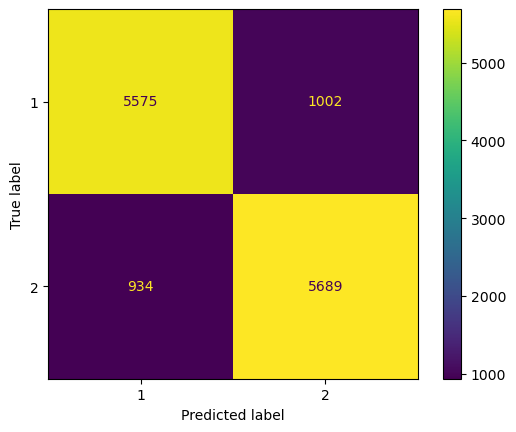

In [21]:
# Displaying confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=BaseLR.classes_)
disp.plot()
plt.show()